In [1]:
import keras_tuner
import keras
from keras import layers
from keras.datasets import boston_housing

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

2025-10-13 20:12:27.120316: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

sample_size, input_size = X_train.shape

In [3]:
keras.utils.set_random_seed(42)
model = keras.Sequential()

model.add(layers.Dense(
    units = 6,
    activation = 'relu',
    input_shape = (input_size,)
))

model.add(layers.Dense(
    units = 6,
    activation = 'relu'
))

model.add(layers.Dense(
    units = 1,
    activation = 'linear'
))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=.01),
    loss=[keras.losses.MeanAbsoluteError()],
    metrics=[keras.metrics.MeanAbsoluteError()]
)

model.summary()

/home/hanibounoua/anaconda3/envs/deep-learning/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6)              │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133 (532.00 B)

 Trainable params: 133 (532.00 B)

 Non-trainable params: 0 (0.00 B)

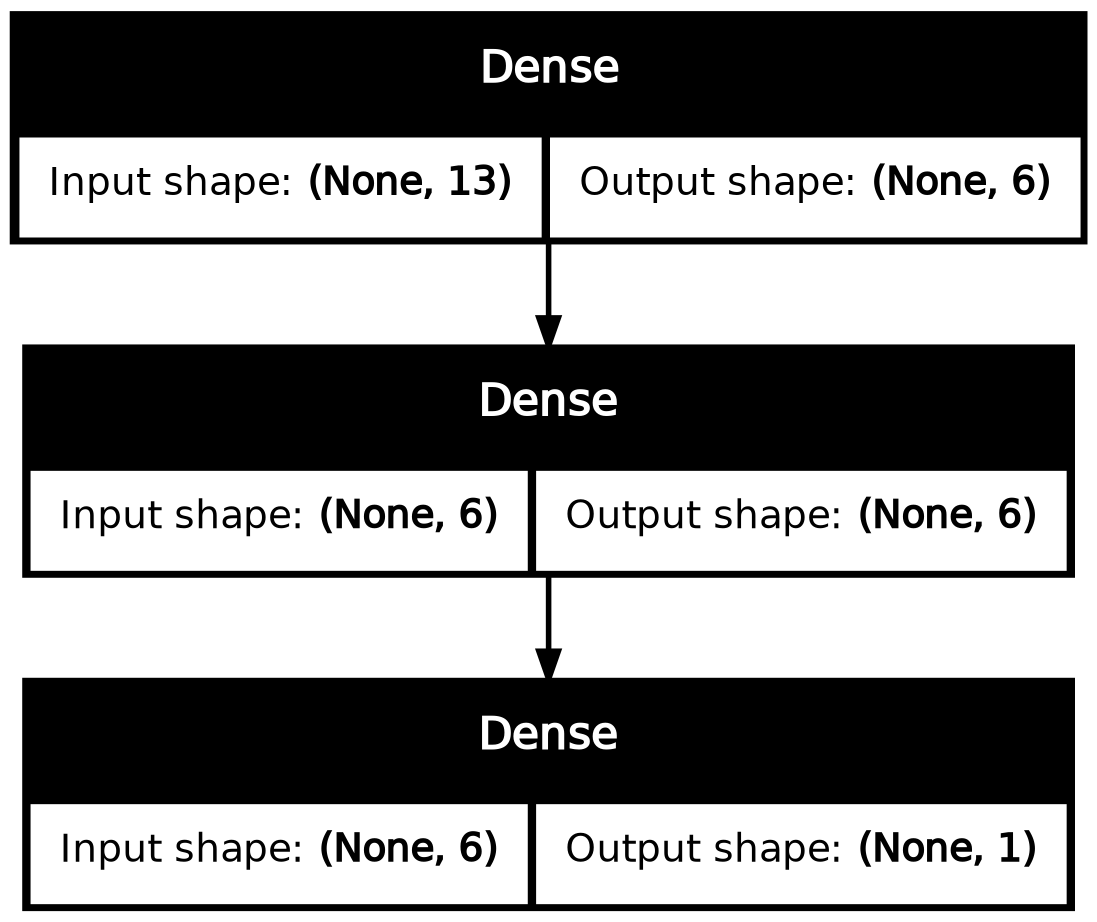

In [28]:
keras.utils.plot_model(model=model, to_file='img/base_boston_housing_model.png', show_shapes=True)

In [5]:
model.fit(x=X_train, y=y_train, validation_split=0.2, epochs=200, batch_size=32)

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 28.3188 - mean_absolute_error: 28.3188 - val_loss: 20.1397 - val_mean_absolute_error: 20.1397
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15.1780 - mean_absolute_error: 15.1780 - val_loss: 8.8656 - val_mean_absolute_error: 8.8656
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0670 - mean_absolute_error: 8.0670 - val_loss: 6.7542 - val_mean_absolute_error: 6.7542
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3747 - mean_absolute_error: 6.3747 - val_loss: 5.6405 - val_mean_absolute_error: 5.6405
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.1332 - mean_absolute_error: 6.1332 - val_loss: 6.6438 - val_mean_absolute_error: 6.6438
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3066 - mean_absolute_error: 5.3066 - val_loss: 5.3214 - val_mean_absolute_error: 5.3214
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3966 - mean_absolute_error: 5.3966 - v

/tmp/ipykernel_108259/3416804024.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


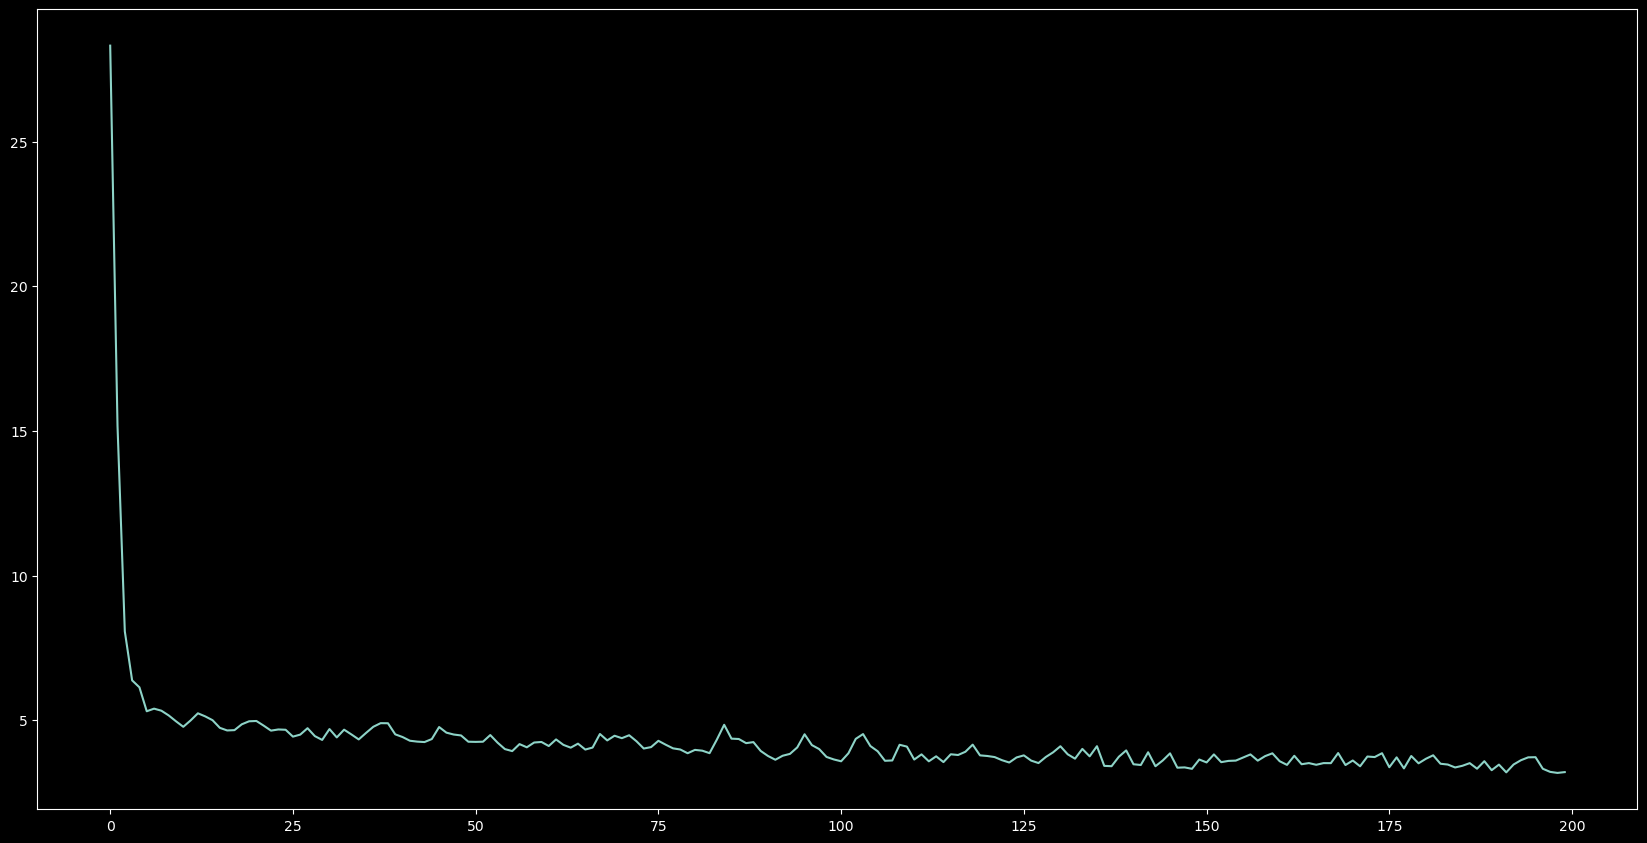

In [6]:
history = model.history

fig = plt.figure(figsize=(16, 8))

ax = fig.add_axes(rect=(0,0,1,1))

ax.plot(history.history['loss'])

fig.show()

In [7]:
test_loss, _ = model.evaluate(X_test, y_test, verbose=False)

print(f'Test MAE : {test_loss}')

Test MAE : 4.273401737213135


In [15]:
def build_model(hp):
    
    model = keras.Sequential()
    
    # Input Layer
    model.add(layers.Input(
        shape = (input_size,)
    ))

    # Number of hidden layers
    n_layers = hp.Int('num_layers', min_value=1, max_value=4, step=2)
    
    # Hidden Layers
    for i in range(n_layers):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=8, max_value=32, step=4),
            activation='relu'
        ))
    
    # Output Layer
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value = .001, max_value = .01, step = .001)),
        loss=[keras.losses.MeanAbsoluteError()],
        metrics=[keras.metrics.MeanAbsoluteError()]
    )
    return model


In [18]:
tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective=keras_tuner.Objective(name='val_loss', direction='min'),
    max_trials=100,
    seed=42
)

tuner.search(X_train, y_train, epochs=200, validation_split=.2)
best_hp = tuner.get_best_hyperparameters()[0]
best_model = build_model(best_hp)
best_model.summary()

Trial 100 Complete [00h 00m 22s]
val_loss: 3.3325986862182617

Best val_loss So Far: 2.6984431743621826
Total elapsed time: 00h 39m 55s


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 8)              │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 28)             │           252 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 605 (2.36 KB)

 Trainable params: 605 (2.36 KB)

 Non-trainable params: 0 (0.00 B)

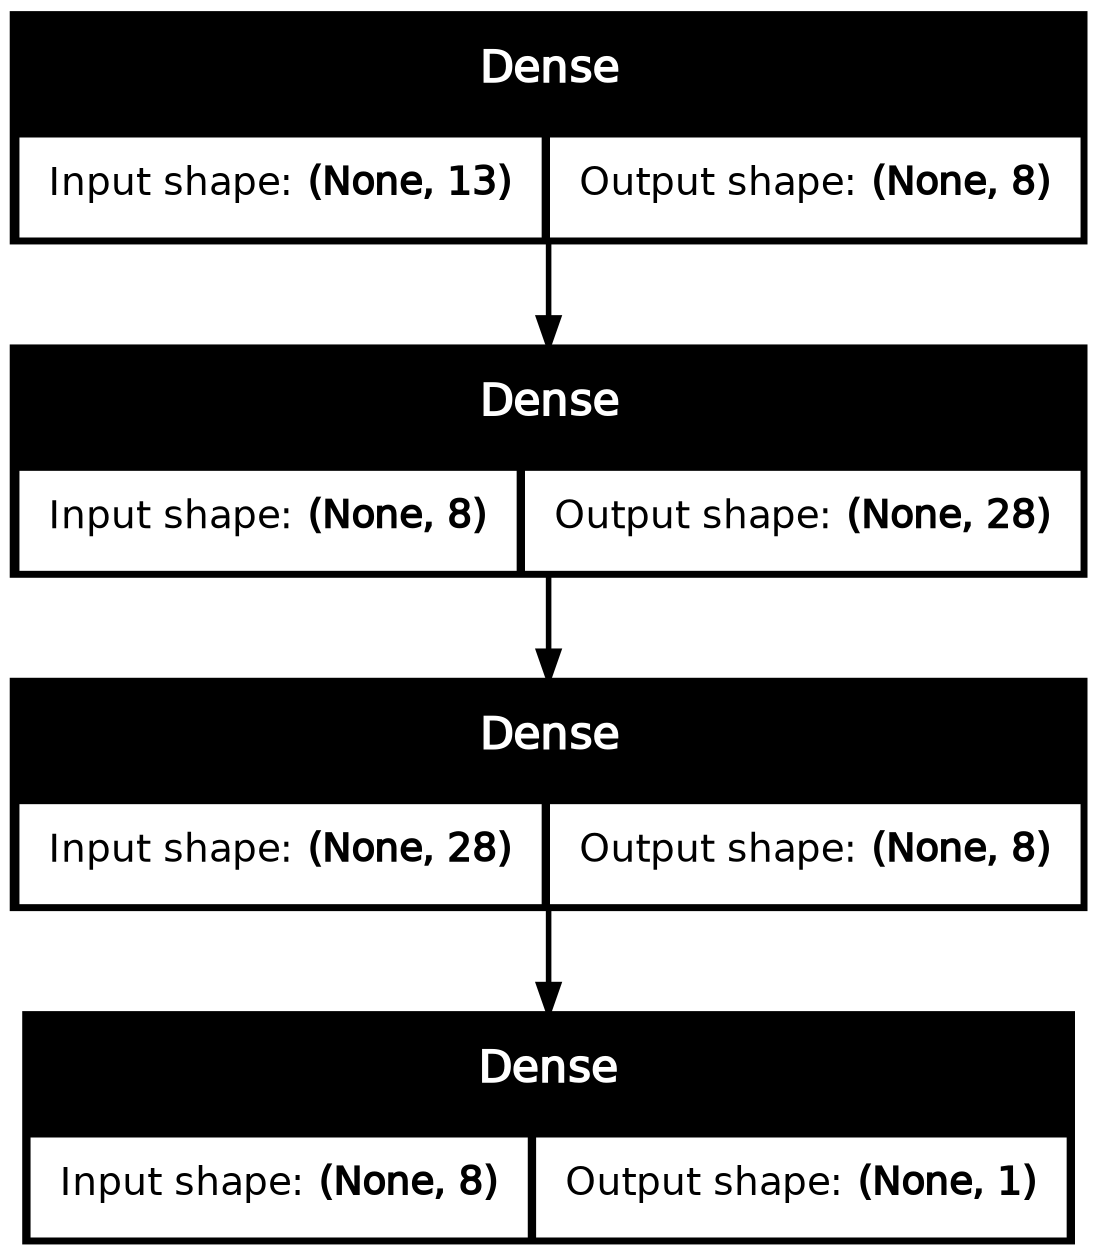

In [27]:
keras.utils.plot_model(to_file='img/tuned_boston_housing_model.png', model=best_model, show_shapes=True)

In [20]:
keras.utils.set_random_seed(42)
best_model.fit(x=X_train, y=y_train, validation_split=0.2, epochs=200, batch_size=32)

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 32.7707 - mean_absolute_error: 32.7707 - val_loss: 10.8636 - val_mean_absolute_error: 10.8636
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.8503 - mean_absolute_error: 8.8503 - val_loss: 7.9412 - val_mean_absolute_error: 7.9412
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5862 - mean_absolute_error: 6.5862 - val_loss: 6.3282 - val_mean_absolute_error: 6.3282
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6441 - mean_absolute_error: 6.6441 - val_loss: 6.4259 - val_mean_absolute_error: 6.4259
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0050 - mean_absolute_error: 6.0050 - val_loss: 5.9397 - val_mean_absolute_error: 5.9397
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8682 - mean_absolute_error: 5.8682 - val_loss: 5.8858 - val_mean_absolute_error: 5.8858
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7077 - mean_absolute_error: 5.7077 - val

/tmp/ipykernel_108259/193817519.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


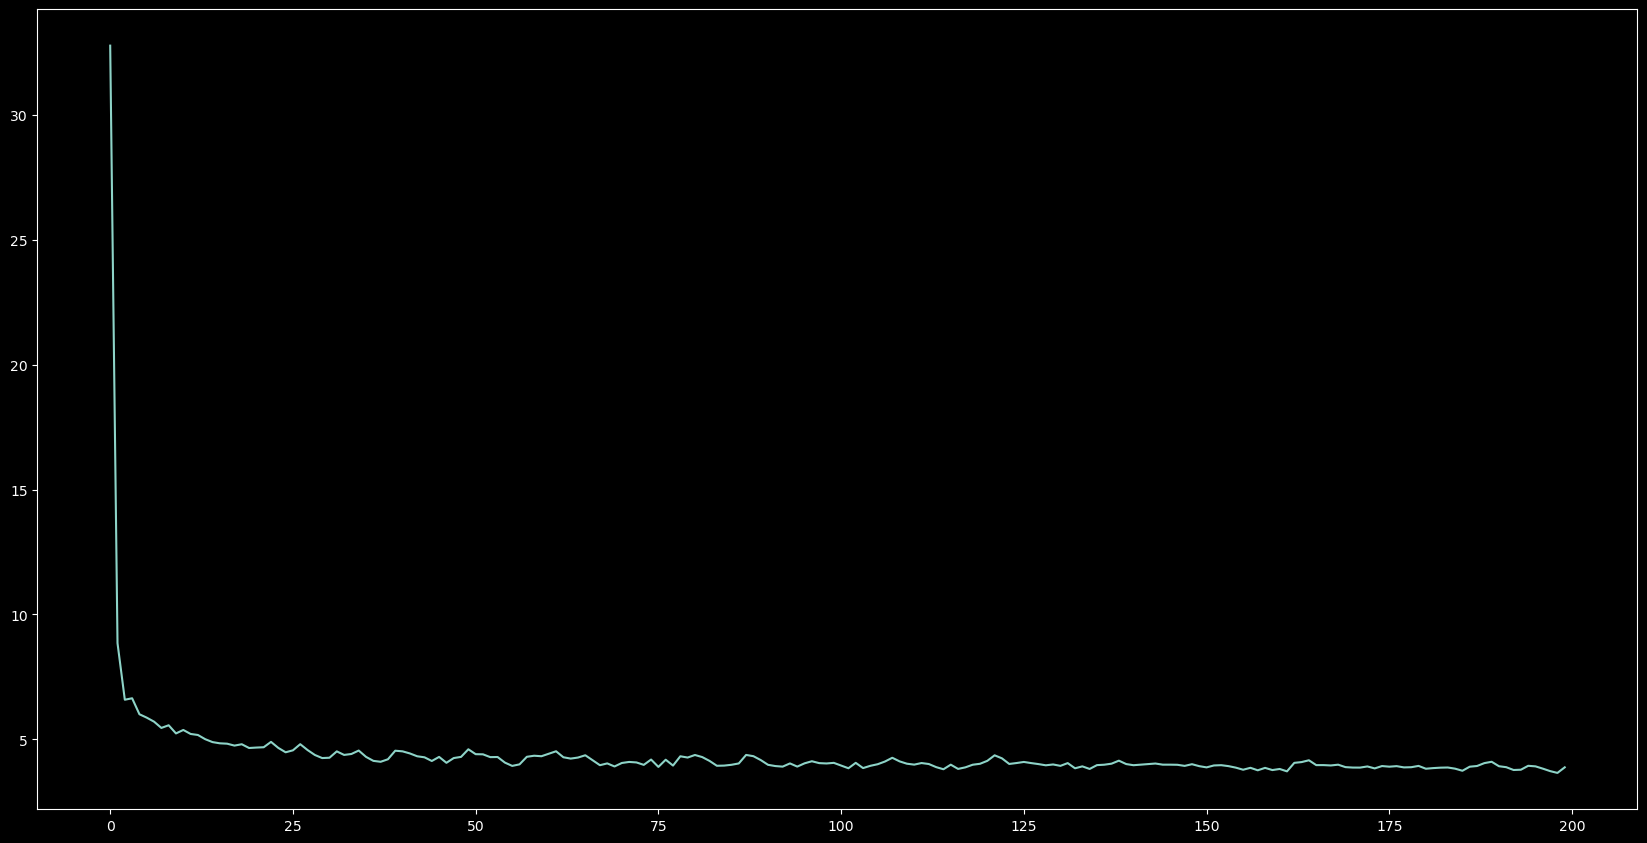

In [21]:
t_history = best_model.history

fig = plt.figure(figsize=(16, 8))

ax = fig.add_axes(rect=(0,0,1,1))

ax.plot(t_history.history['loss'])

fig.show()

In [22]:
ttest_loss, _ = best_model.evaluate(X_test, y_test, verbose=False)
print(f'Test MAE : {ttest_loss}')

Test MAE : 4.420924663543701


In [24]:
best_model.save('./models/tunned_boston_housing_model.keras') # save tunned model

In [25]:
loaded_model = keras.saving.load_model('./models/tunned_boston_housing_model.keras')